# Online Feature selection for all models

### Importing Libraries

In [47]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper
from sklearn.feature_selection import SelectPercentile, chi2, f_classif


from helpers import load_data, roc_plt

### Importing data

In [2]:
##load the data 

DATA_PATH = '../data/'
PICKLE_PATH = '../pickles/'
seed = 7

master_data = load_data(DATA_PATH)
X, y = master_data['muchlinski']

In [3]:
def get_params(method):
    file = "gs_rocauc_" + method +"_all.pkl"
    with open(PICKLE_PATH + file, "rb") as f:
        params = pickle.load(f)
        params = params.drop('roc_auc',axis=1).iloc[0].to_dict()
    if method == "svm" and np.isnan(params["degree"]):
        params["degree"] = 1
    if "n_estimators" in params:
        params["n_estimators"] = int(params["n_estimators"])
    return params

def save_pkl(object_, file):
    with open(PICKLE_PATH + file + ".pkl", "wb") as f:
        pickle.dump(object_, f, pickle.HIGHEST_PROTOCOL)

### Creating the models

In [4]:
params_brf = get_params("brf")
params_bdt = get_params("bdt")
params_knn = get_params("knn")
params_svm = get_params("svm")

BRF = BalancedRandomForestClassifier(random_state = 0)
KNN = KNeighborsClassifier()
SVM = SVC(random_state = 0)
BDT = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(), random_state = 0)

BRF.set_params(**params_brf)
KNN.set_params(**params_knn)
SVM.set_params(**params_svm)
BDT.set_params(**params_bdt)

STD = StandardScaler()

In [68]:
def categorical_filter(df, low_exclusive = 2, high_inclusive = 15):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories

    """
    list_of_features = []
    for i in df.columns:
        if low_exclusive == high_inclusive:
            if df[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if high_inclusive >= df[i].nunique() > low_exclusive :
                list_of_features.append(i)
    return list_of_features

In [69]:
def get_col_indexes(df, cols):
    return [df.columns.get_loc(c) for c in cols if c in df]

In [71]:
cat = categorical_filter(X, 1, 15)
num = X.columns.difference(cat)

cat = get_col_indexes(X, cat)
num = get_col_indexes(X, num)

In [78]:
chi =  SelectPercentile(chi2, percentile=30)
clf = LinearDiscriminantAnalysis()

fe = ColumnTransformer(
    transformers=[
        ('num', clf, num),
        ('cat', chi, cat)])

### Creating the pipelines

In [79]:
pipe_BRF = Pipeline([('rfe',fe), ('std',STD), ('clf',BRF)])
pipe_KNN = Pipeline([('rfe',fe), ('std',STD), ('clf',KNN)])
pipe_SVM = Pipeline([('rfe',fe), ('std',STD), ('clf',SVM)])
pipe_BDT = Pipeline([('rfe',fe), ('std',STD), ('clf',BDT)])

### Plottings

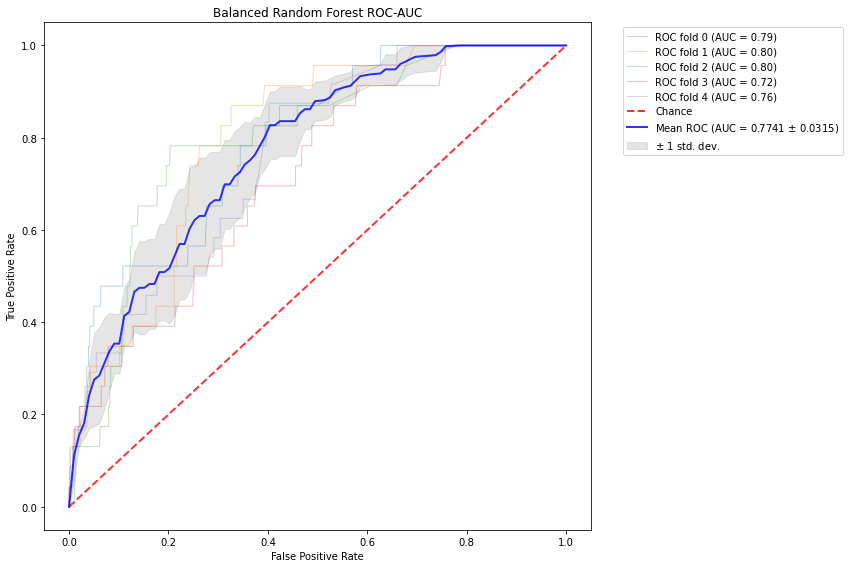

In [80]:
brf_res = roc_plt(X, y, pipe_BRF, "Balanced Random Forest ROC-AUC", seed=seed, create_plot=True)
save_pkl(brf_res, "brf_res_ROC_RFE")

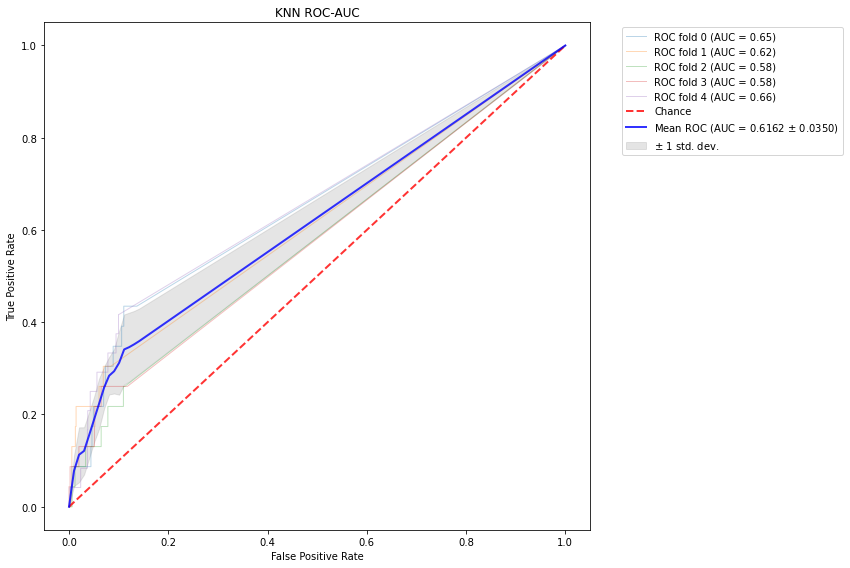

In [81]:
knn_res = roc_plt(X, y, pipe_KNN, "KNN ROC-AUC", seed=seed, create_plot=True)
save_pkl(knn_res, "knn_res_ROC_RFE")

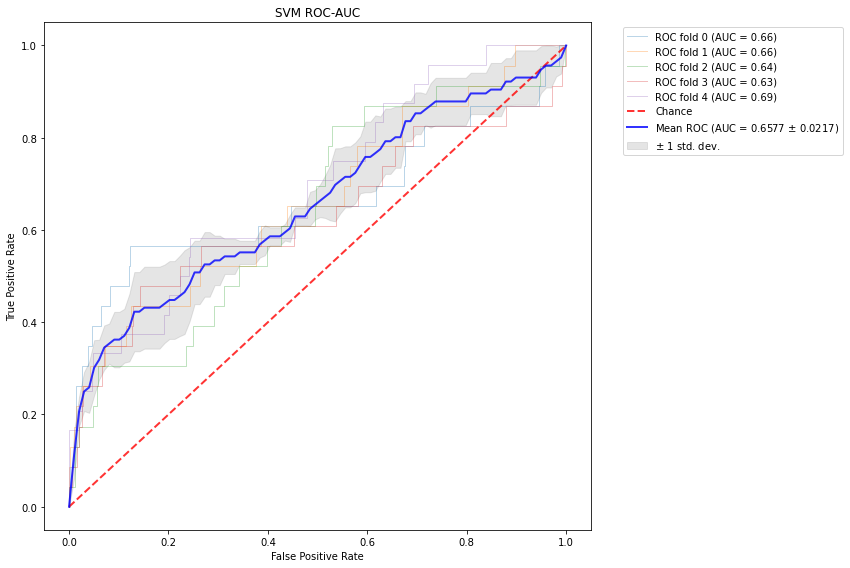

In [82]:
svm_res = roc_plt(X, y, pipe_SVM, "SVM ROC-AUC", seed=seed, create_plot=True)
save_pkl(svm_res, "svm_res_ROC_RFE")

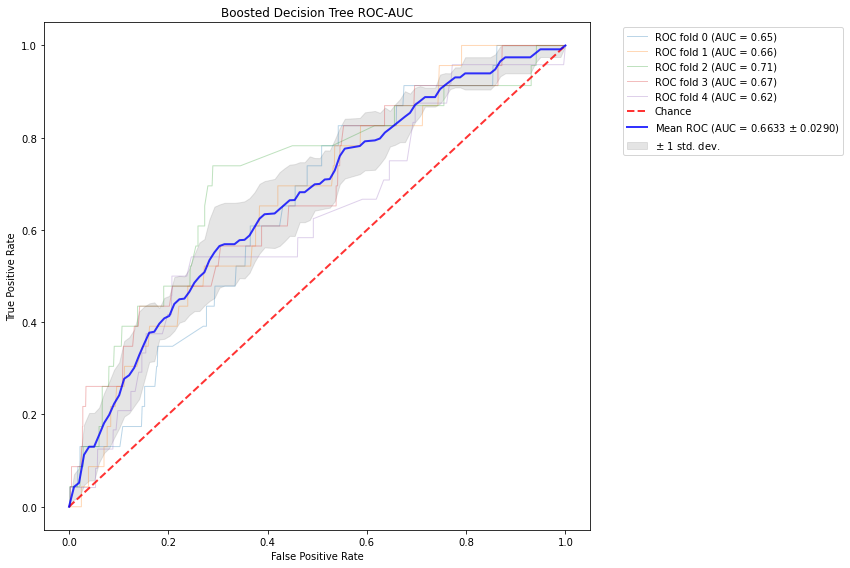

In [83]:
bdt_res = roc_plt(X, y, pipe_BDT, "Boosted Decision Tree ROC-AUC", seed=seed, create_plot=True)
save_pkl(bdt_res, "bdt_res_ROC_RFE")